# Notebook Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import logging
import numpy as np
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib


# Functions

In [15]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, log_every=1000):
        self.log_every = log_every
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([
            self._preprocess(text, idx) for idx, text in enumerate(X)
        ])

    def _preprocess(self, text, idx=None):
        if idx is not None and self.log_every and idx % self.log_every == 0:
            logging.info(f"Preprocessing row {idx}")

        text = re.sub(r"<.*?>", " ", text)
        text = re.sub(r"[^a-zA-Z]", " ", text).lower()
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stop_words]
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(tokens)

# Loading Data

In [2]:
cleaned_data = pd.read_pickle('cleaned_data.pkl')
cleaned_data

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


# Fitting and training TF-IDF model

In [8]:
# Map sentiment to binary (positive → 1, negative → 0)
cleaned_data['sentiment'] = cleaned_data['sentiment'].map({'positive': 1, 'negative': 0})

In [9]:
# Split into training and testing sets
X = cleaned_data['review']
y = cleaned_data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Create TF-IDF + Logistic Regression pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])

In [11]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=1000))])

# Evaluation of the model

In [12]:
# Evaluate
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8873424104891579

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4936
           1       0.87      0.91      0.89      4979

    accuracy                           0.89      9915
   macro avg       0.89      0.89      0.89      9915
weighted avg       0.89      0.89      0.89      9915



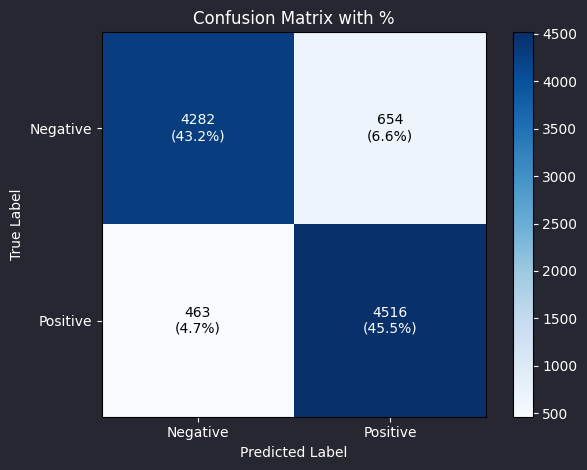

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix and normalize it
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum() * 100

labels = ["Negative", "Positive"]
fig, ax = plt.subplots()
fig.patch.set_facecolor('#262730')
ax.set_facecolor('#262730')

# Display heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Colorbar with white ticks
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Axis labels and title
ax.set_title("Confusion Matrix with %", color='white')
tick_marks = np.arange(len(labels))
ax.set(
    xticks=tick_marks,
    yticks=tick_marks,
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True Label',
    xlabel='Predicted Label'
)

# Set axis label and tick color to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Annotate each cell with count and percent
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        ax.text(j, i, f'{count}\n({percent:.1f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [22]:
# Instantiate your preprocessor
preprocessor = TextPreprocessor()

# New raw reviews
new_reviews = ["I absolutely loved the movie!", "It was a boring and predictable film."]

# Preprocess the new reviews
preprocessed_reviews = [preprocessor._preprocess(review) for review in new_reviews]

# Predict
predictions = pipeline.predict(preprocessed_reviews)

# Output
for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")



Review: I absolutely loved the movie!
Predicted Sentiment: Positive

Review: It was a boring and predictable film.
Predicted Sentiment: Negative



# Saving the model

In [ ]:
# Save to a file
joblib.dump(pipeline, '../models/TF-IDF_trained_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [7]:
# Load the saved model
loaded_model = joblib.load(R'../models/TF-IDF_trained_model.pkl')

# Use it to predict on new reviews
new_reviews = ["Absolutely loved it!", "Terrible movie, waste of time."]
predictions = loaded_model.predict(new_reviews)

for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: Absolutely loved it!
Predicted Sentiment: Positive

Review: Terrible movie, waste of time.
Predicted Sentiment: Negative

